In [1]:
# For importing utils
import sys
sys.path.append("..")

In [2]:
from utils import PERTURBATIONS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from glob import glob

/nlp/scr/kallini/miniconda3/envs/mission-impossible-2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_datasets(ax, datasets, data_path, layer, checkpoints):

    for dataset in datasets:
        # Filter the data for the layer and available checkpoints
        all_seeds_layer_data = []

        files_for_all_seeds = glob(data_path.format(dataset['data']))
        for file in files_for_all_seeds:
            df = pd.read_csv(file)
            layer_data = df[df['GPT-2 Layer'] == layer][[f'Accuracy (ckpt {cp})' for cp in checkpoints]].T
            layer_data.columns = [dataset['label']]
            all_seeds_layer_data.append(list(layer_data[dataset['label']]))
        
        all_seeds_layer_data = np.array(all_seeds_layer_data) * 100.0
        means = np.mean(all_seeds_layer_data, axis=0)

        ci = None
        if len(files_for_all_seeds) > 1:
            sems = stats.sem(all_seeds_layer_data, axis=0)
            # Calculate confidence interval using t-distribution
            ci_lower, ci_upper = stats.t.interval(0.95, df=len(files_for_all_seeds)-1,
                                                  loc=means, scale=sems)
            ci = (ci_upper - ci_lower) / 2

        # Plotting the data for the layer
        ax.errorbar(checkpoints, means, ci, marker=dataset['marker'], linestyle=dataset['linestyle'],
                    color=PERTURBATIONS[dataset['data']]['color'], label=dataset['label'])

## Plot Accuracy by Averaging Last 4 Layers

In [4]:
def plot_accuracy(rev_datasets, hop_datasets, agree_datasets, neg_datasets, model_type, checkpoints):

    # Setting up the plot with all subplots in a single row
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 4), sharey=False)

    fig.supxlabel("Training Steps", y=-0.01)
    fig.suptitle("Probe Accuracy", x=-0.01)

    data_path = "constituency_probing_results/{}" + f"_{model_type}/mean_pooling_seed*.csv"

    # Plotting the data
    axes[0].set_ylabel("Probe Accuracy", fontsize=12)

    # Plot *Reverse
    plot_datasets(axes[0], rev_datasets, data_path, "Avg Last 4", checkpoints)
    axes[0].set_title("*Reverse")
    axes[0].grid(True)
    axes[0].legend(loc='lower right', framealpha=1)

    # Plot *Hop
    plot_datasets(axes[1], hop_datasets, data_path, "Avg Last 4", checkpoints)
    axes[1].set_title("*Hop")
    axes[1].grid(True)
    axes[1].legend(loc='lower right', framealpha=1)

    # Plot *Agreement
    plot_datasets(axes[2], agree_datasets, data_path, "Avg Last 4", checkpoints)
    axes[2].set_title("*Agreement")
    axes[2].grid(True)
    axes[2].legend(loc='lower right', framealpha=1)

    # Plot *Agreement
    plot_datasets(axes[3], neg_datasets, data_path, "Avg Last 4", checkpoints)
    axes[3].set_title("*Negation")
    axes[3].grid(True)
    axes[3].legend(loc='lower right', framealpha=1)

    if model_type == "gpt2":
        model_type_title = "GPT-2 with Absolute Position Embeddings"
    elif model_type == "alibi":
        model_type_title = "GPT-2 with ALiBi"
    elif model_type == "rope":
        model_type_title = "GPT-2 with RoPE"
        
    plt.suptitle(f"Constituency Probe Accuracy\nfor {model_type_title}", fontsize=14, y=1.06)

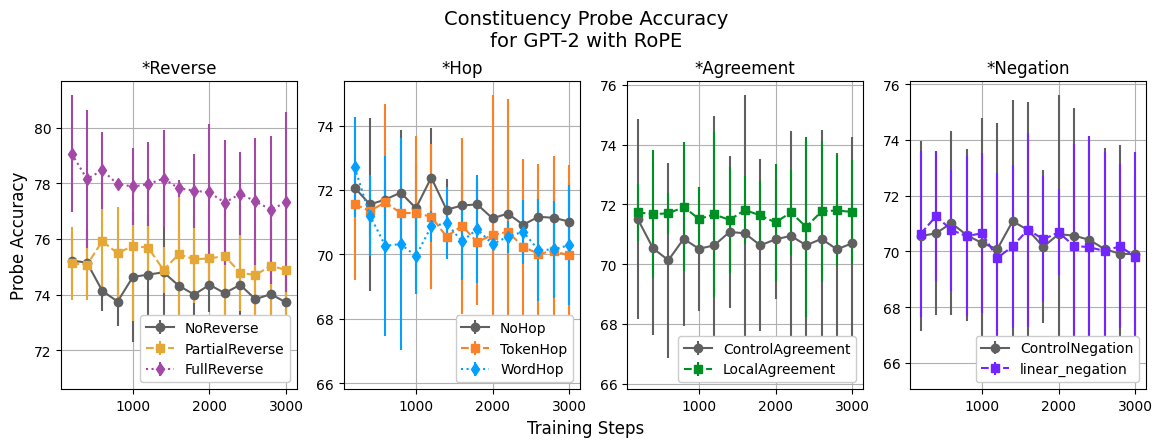

In [5]:
CHECKPOINTS = list(range(200, 3000+1, 200))

# Define the input files, layers, and checkpoints
rev_files = [
    {'data': 'reverse_control',
     'label': 'NoReverse',
     'linestyle': '-',
     'marker': 'o',
    },
    {'data': 'reverse_partial',
     'label': 'PartialReverse',
     'linestyle': '--',
     'marker': 's',
    },
    {'data': 'reverse_full',
     'label': 'FullReverse',
     'linestyle': ':',
     'marker': 'd',
    },
]
hop_files = [
    {'data': 'hop_control',
     'label': 'NoHop',
     'linestyle': '-',
     'marker': 'o',
    },
    {'data': 'hop_tokens4',
     'label': 'TokenHop',
     'linestyle': '--',
     'marker': 's',
    },
    {'data': 'hop_words4',
     'label': 'WordHop',
     'linestyle': ':',
     'marker': 'd',
    },
]
agree_files = [
    {'data': 'agreement_control',
     'label': 'ControlAgreement',
     'linestyle': '-',
     'marker': 'o',
    },
    {'data': 'agreement_local',
     'label': 'LocalAgreement',
     'linestyle': '--',
     'marker': 's',
    },
]
neg_files = [
    {'data': 'negation_control',
     'label': 'ControlNegation',
     'linestyle': '-',
     'marker': 'o',
    },
    {'data': 'negation_linear',
     'label': 'linear_negation',
     'linestyle': '--',
     'marker': 's',
    },
]

# Generate the plot
# plot_accuracy(rev_files, hop_files, agree_files, neg_files, "gpt2", CHECKPOINTS)
# plot_accuracy(rev_files, hop_files, agree_files, neg_files, "alibi", CHECKPOINTS)
plot_accuracy(rev_files, hop_files, agree_files, neg_files, "rope", CHECKPOINTS)

## Plot Accuracy with Individual Layers

In [6]:
def plot_accuracy_layer(datasets, layers, model_type, checkpoints, language_class):

    # Setting up the plot with all subplots in a single row
    fig, axes = plt.subplots(nrows=1, ncols=len(layers), figsize=(4 * len(layers), 4), sharey=True)
    fig.subplots_adjust(wspace=0)
    fig.supxlabel("Training Steps", y=-0.01)
    if len(layers) == 1:
        axes = [axes]

    data_path = "constituency_probing_results/{}" + f"_{model_type}/mean_pooling_seed*.csv"

    # Plotting the data
    for i, layer in enumerate(layers):
        ax = axes[i]
        if i == 0:
            ax.set_ylabel("Probe Accuracy", fontsize=12)

        # Main plotting function
        plot_datasets(ax, datasets, data_path, layer, checkpoints)

        # Setting plot details
        ax.set_title(f'Layer {layer}')
        ax.grid(True)

        if i != 0:
            for tick in ax.yaxis.get_major_ticks():
                tick.tick1line.set_visible(False)
                tick.tick2line.set_visible(False)
        
        if i == len(layers) - 1:
            ax.legend(loc='lower right', framealpha=1)

    if model_type == "gpt2":
        model_type_title = "GPT-2 with Absolute Position Embeddings"
    elif model_type == "alibi":
        model_type_title = "GPT-2 with ALiBi"
    elif model_type == "rope":
        model_type_title = "GPT-2 with RoPE"

    plt.suptitle(f"{language_class}—{model_type_title}", fontsize=14, y=1.01)
            

In [7]:
LAYERS = [str(l) for l in [1, 3, 6, 9, 12]]
CHECKPOINTS = list(range(200, 3000+1, 200))

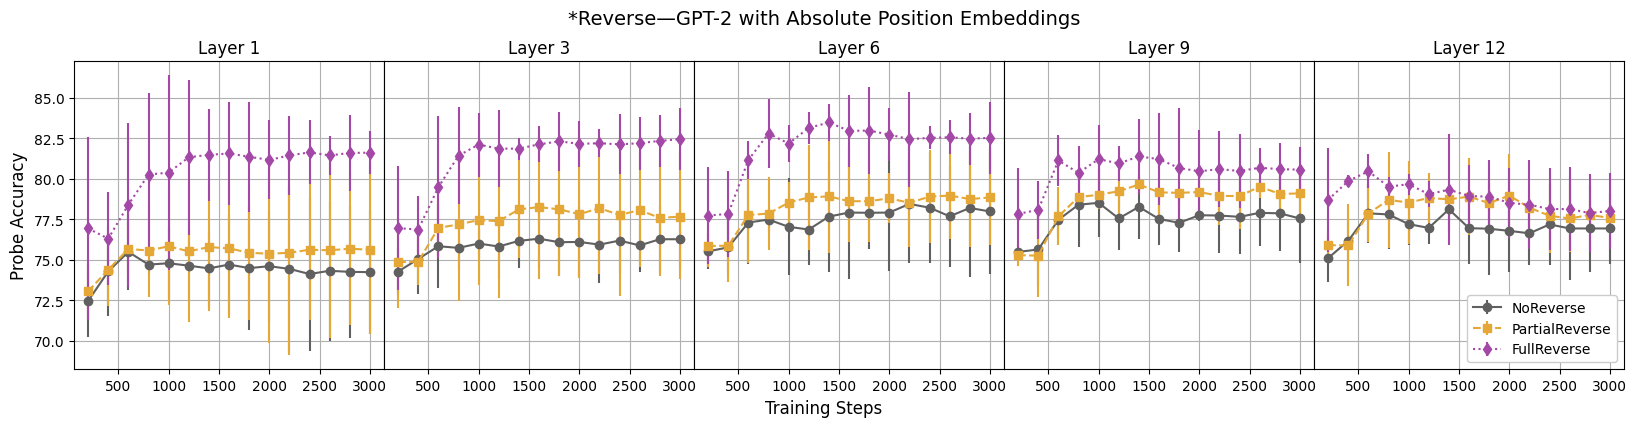

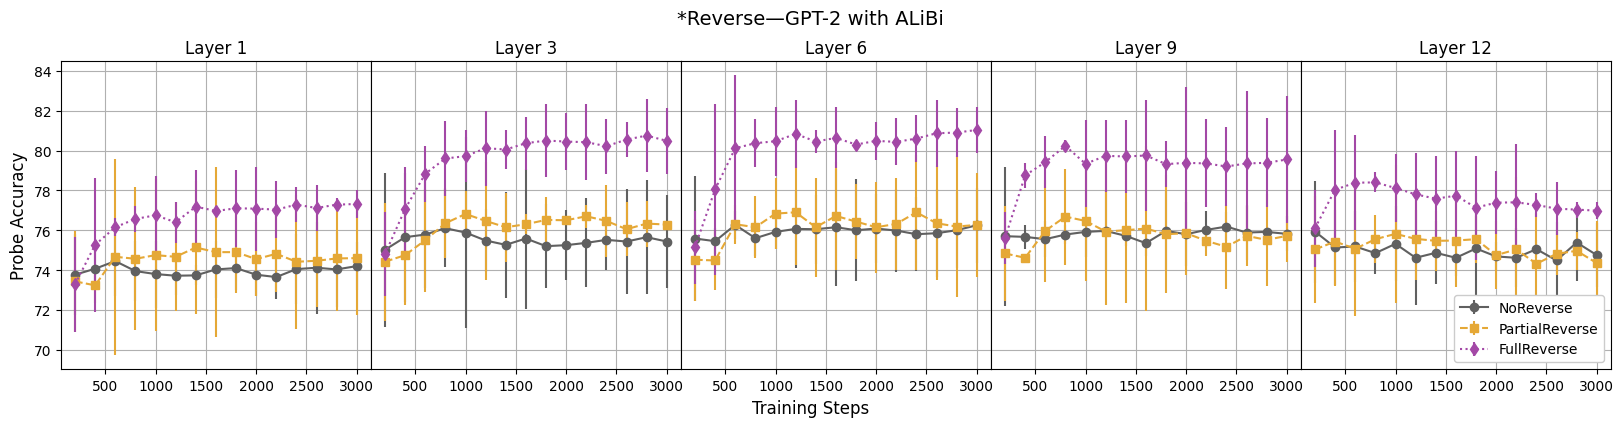

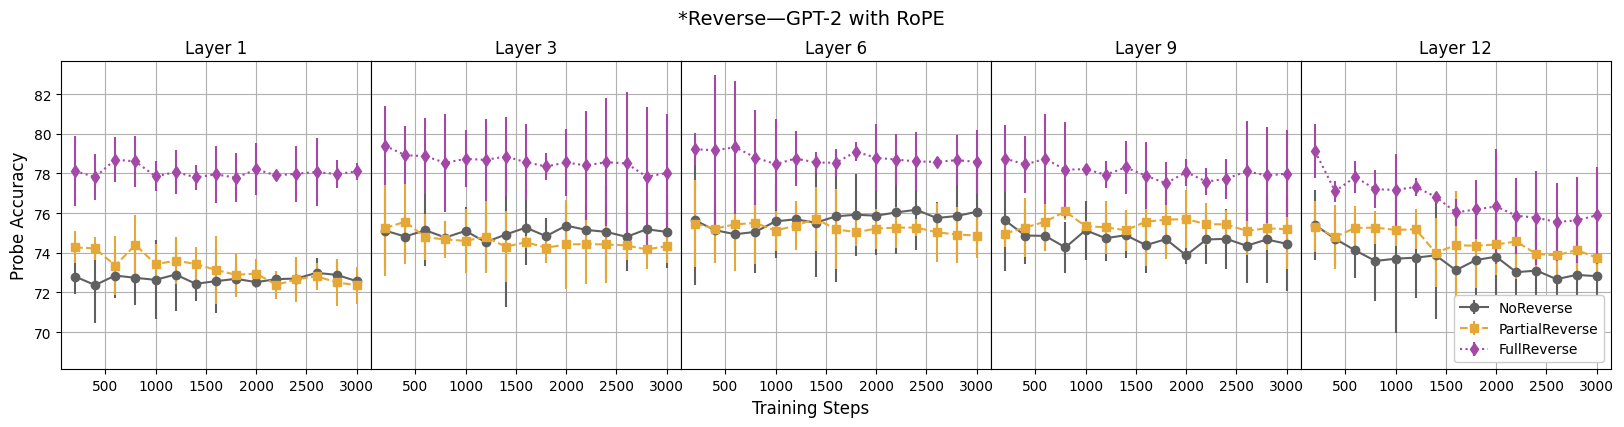

In [8]:
# Generate the plot
plot_accuracy_layer(rev_files, LAYERS, "gpt2", CHECKPOINTS, "*Reverse")
plot_accuracy_layer(rev_files, LAYERS, "alibi", CHECKPOINTS, "*Reverse")
plot_accuracy_layer(rev_files, LAYERS, "rope", CHECKPOINTS, "*Reverse")


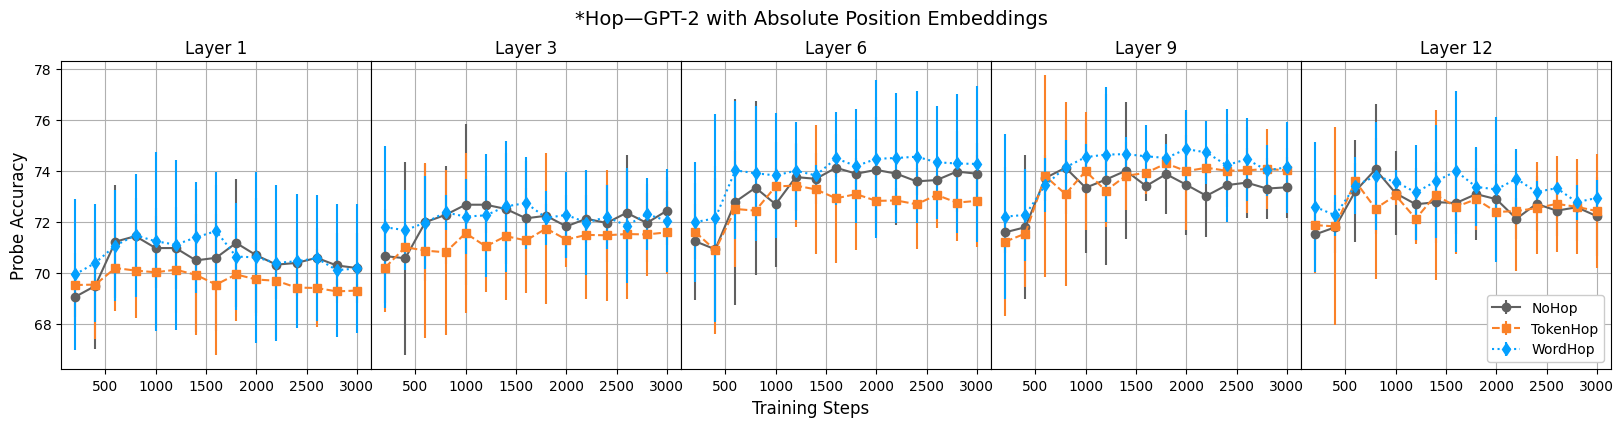

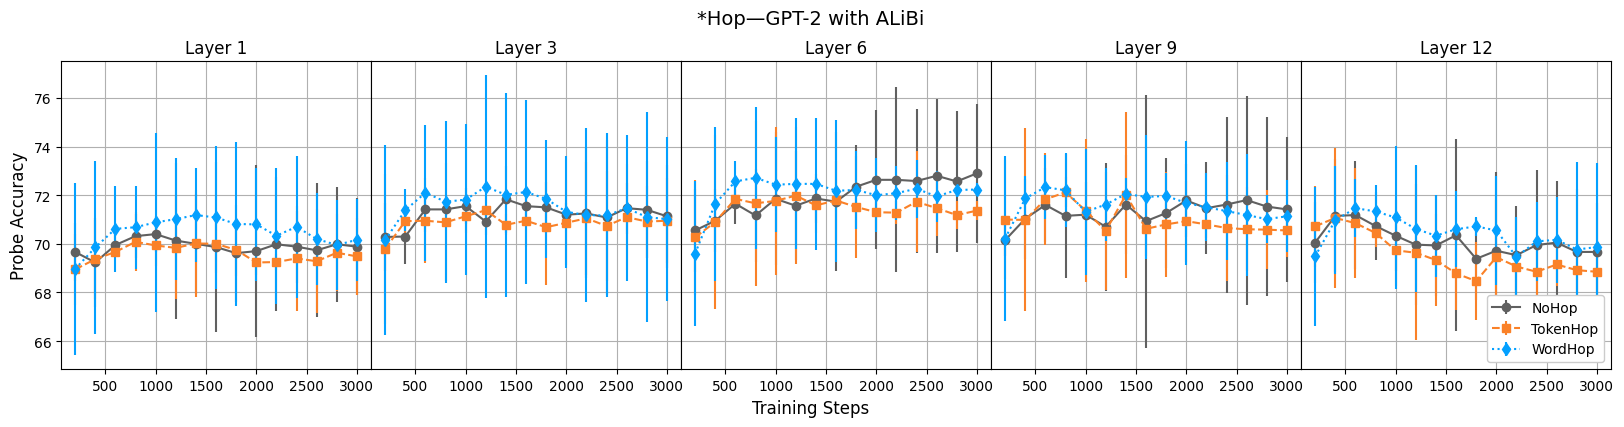

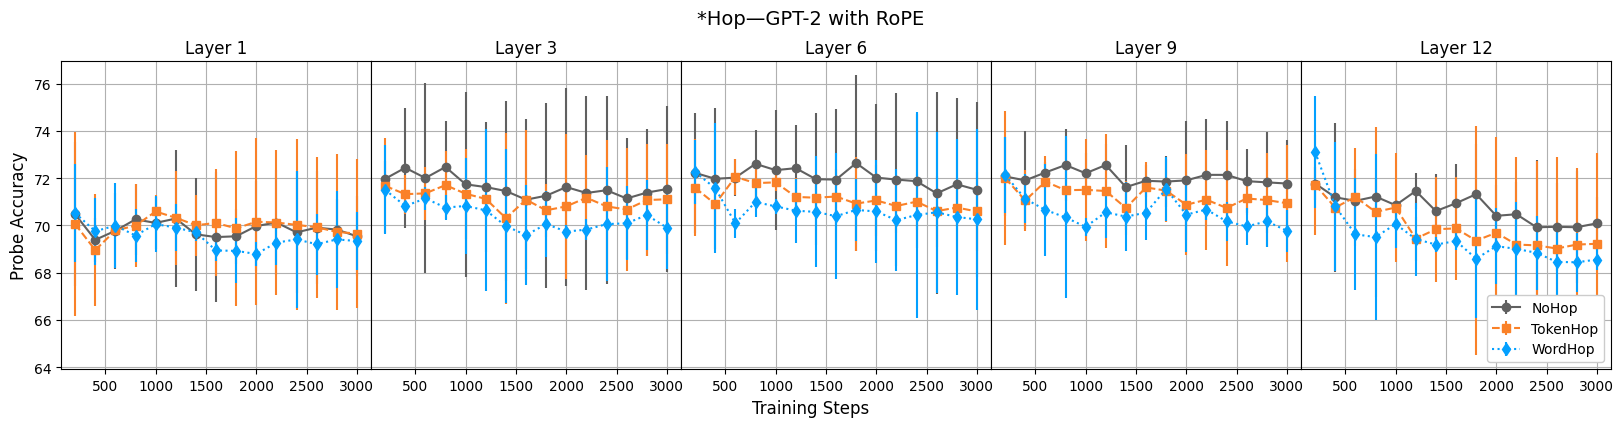

In [9]:
# Generate the plot
plot_accuracy_layer(hop_files, LAYERS, "gpt2", CHECKPOINTS, "*Hop")
plot_accuracy_layer(hop_files, LAYERS, "alibi", CHECKPOINTS, "*Hop")
plot_accuracy_layer(hop_files, LAYERS, "rope", CHECKPOINTS, "*Hop")

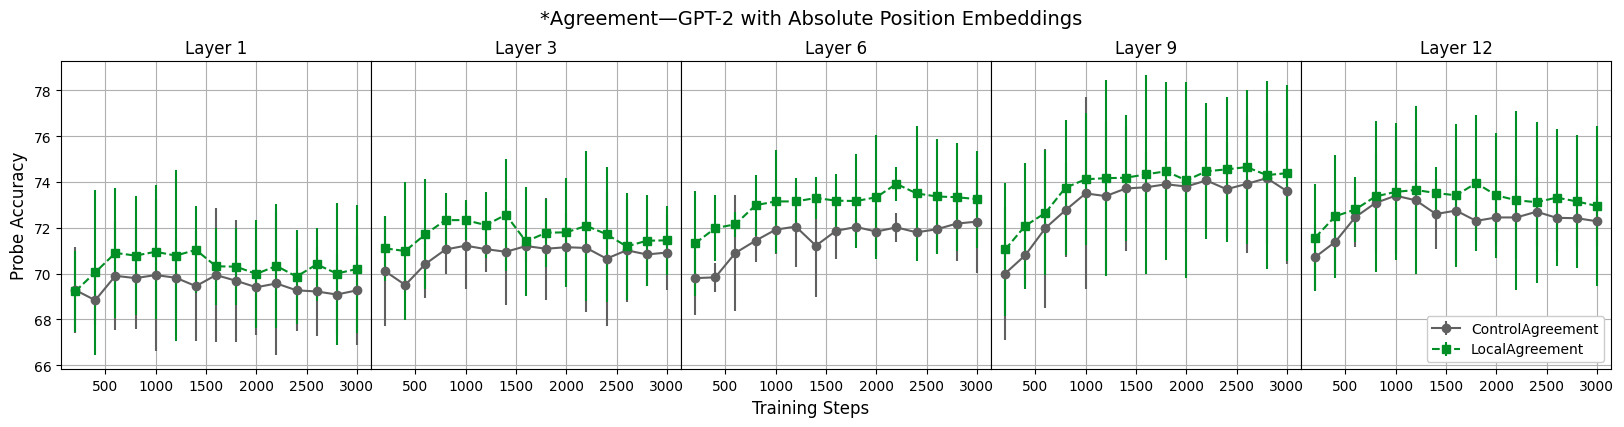

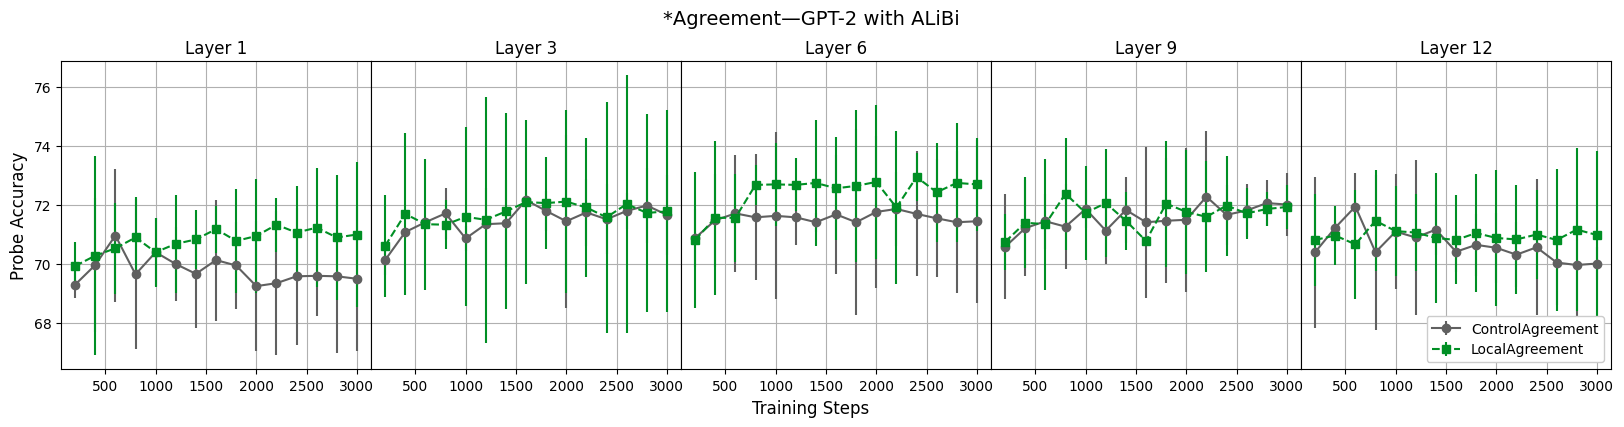

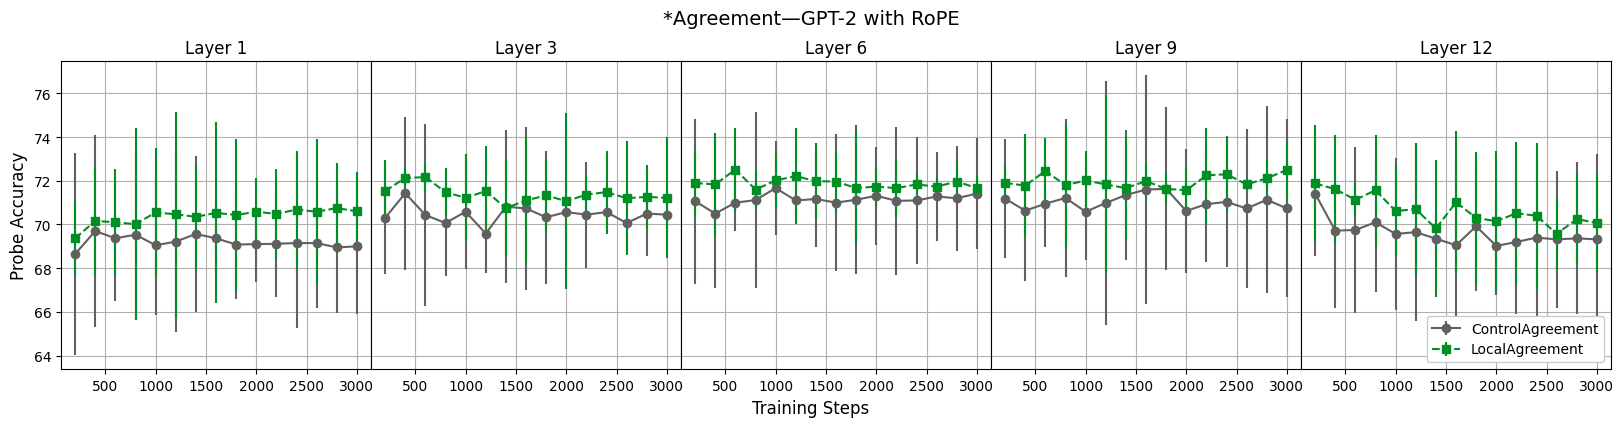

In [10]:
# Generate the plot
plot_accuracy_layer(agree_files, LAYERS, "gpt2", CHECKPOINTS, "*Agreement")
plot_accuracy_layer(agree_files, LAYERS, "alibi", CHECKPOINTS, "*Agreement")
plot_accuracy_layer(agree_files, LAYERS, "rope", CHECKPOINTS, "*Agreement")

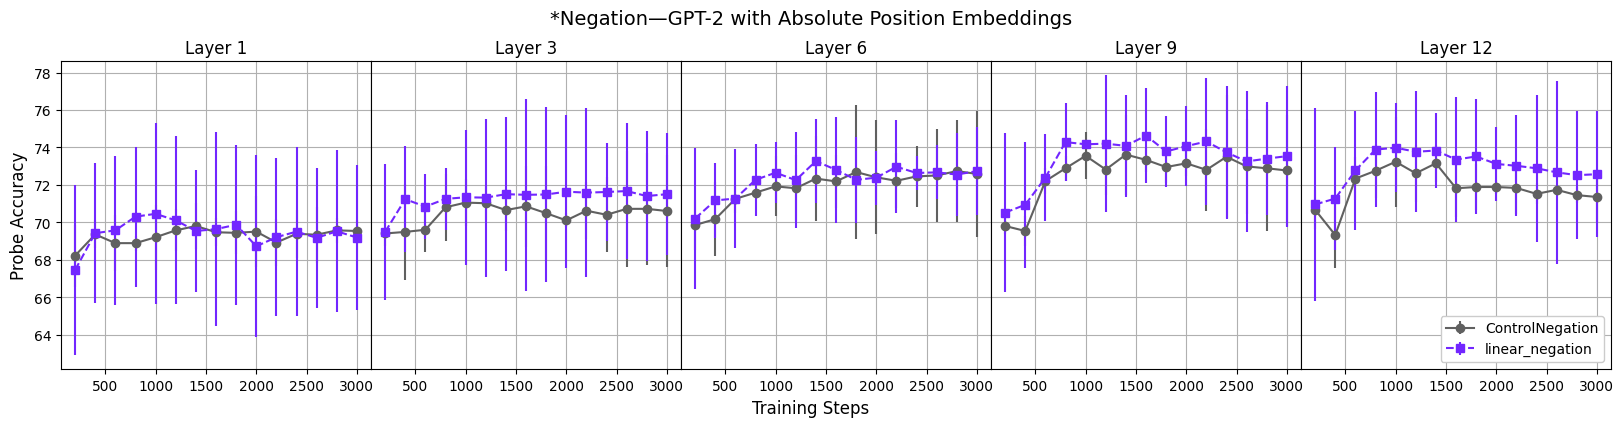

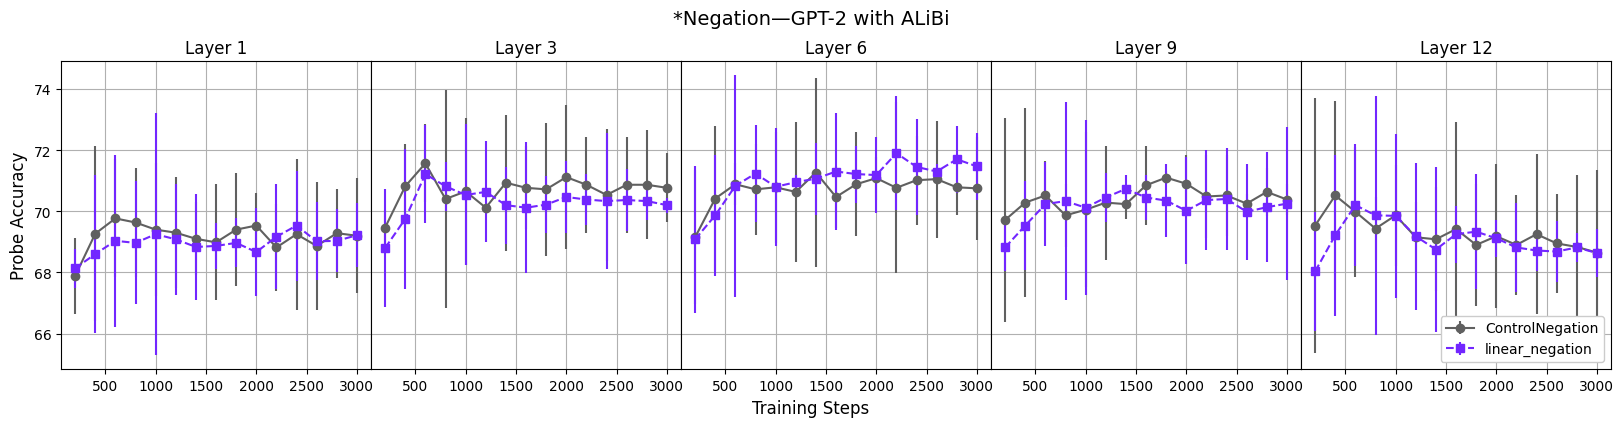

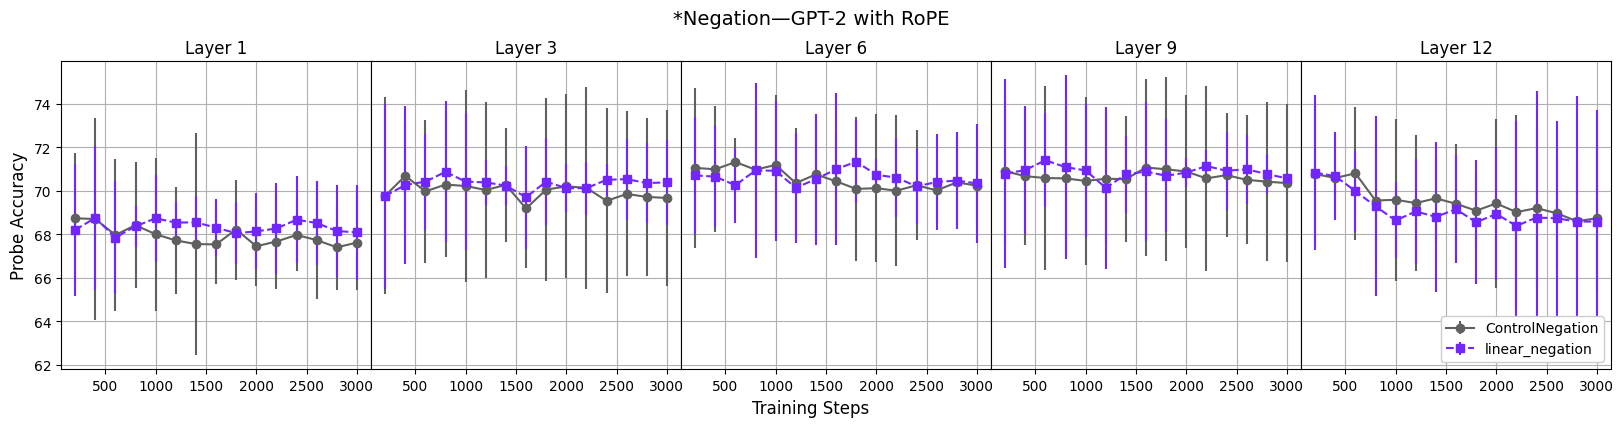

In [11]:
# Generate the plot
plot_accuracy_layer(neg_files, LAYERS, "gpt2", CHECKPOINTS, "*Negation")
plot_accuracy_layer(neg_files, LAYERS, "alibi", CHECKPOINTS, "*Negation")
plot_accuracy_layer(neg_files, LAYERS, "rope", CHECKPOINTS, "*Negation")